In [6]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import PIL
from PIL import Image
import scipy.misc
import random
import pandas as pd
import tensorflow as tf
import h5py



Need a function to clean image data and open matlab files.  Found this on github using the h5py package

In [2]:
# Found this function on github @username
def get_data_boxes(dsf, start_range, end_range):    
    
    dsf_name = dsf['digitStruct']['name']
    dsf_box = dsf['digitStruct']['bbox']
    train_data_boxes = {}
    
    for i in range(start_range, end_range):
        img_file = dsf[dsf_name[i][0]].value.tostring().replace("\x00","")
        boxes = []
        boxes_count = len(dsf[dsf_box[i].item()]["label"])
        if boxes_count > 1:
            for j in range(boxes_count):
                box = {}
                box["top"] = dsf[dsf[dsf_box[i].item()]["top"].value[j].item()].value[0][0]
                box["left"] = dsf[dsf[dsf_box[i].item()]["left"].value[j].item()].value[0][0]
                box["height"] = dsf[dsf[dsf_box[i].item()]["height"].value[j].item()].value[0][0]
                box["width"] = dsf[dsf[dsf_box[i].item()]["width"].value[j].item()].value[0][0]
                box["label"] = dsf[dsf[dsf_box[i].item()]["label"].value[j].item()].value[0][0]
                boxes.append(box)
        else:
            box = {}
            box["top"] = dsf[dsf_box[i].item()]["top"].value[0][0]
            box["left"] = dsf[dsf_box[i].item()]["left"].value[0][0]
            box["height"] = dsf[dsf_box[i].item()]["height"].value[0][0]
            box["width"] = dsf[dsf_box[i].item()]["width"].value[0][0]
            box["label"] = dsf[dsf_box[i].item()]["label"].value[0][0]            
            boxes.append(box)
    
        train_data_boxes[img_file] = boxes    
    
    return train_data_boxes

Writing fucntion to crop images based on the bounding boxes and extract the label

In [3]:
#fucntion to clean and simplify image
def greyscale_crop_resize(path, img_name, bbox, new_size, i = 0):
    
    #change 10 label to 0
    def get_label(bbox):
        y = [str(int(i['label'])) for i in bbox]
        y = ['0' if i == '10' else i for i in y]
        y = ''.join(y)
        return y
    
    label = get_label(bbox[img_name])
    
    try:
        #convert image to array
        filename = path + img_name
        img = Image.open(filename)
        img = misc.fromimage(img, flatten = True)
        img = np.array(img)

        L1 = bbox[img_name][0]['left']
        L2 = bbox[img_name][-1]['left']
        H1 = bbox[img_name][0]['height']
        H2 = bbox[img_name][-1]['height']
        W1 = bbox[img_name][0]['width']
        W2 = bbox[img_name][-1]['width']
        T1 = bbox[img_name][0]['top']
        T2 = bbox[img_name][-1]['top']

        #if image slanting up or down do the following
        if (T2-T1) < 0.: #slantup
            y_top = T2
            height = H1 + abs(H2-H1)
            y_bottom = T1 + height
            x_left = L1
            x_right = L2 + W2

        if (T2-T1) > 0: #slantdown
            y_top = T1
            height = H1 + abs(H2-H1)
            y_bottom = T2 + height + abs(H2-H1)
            x_left = L1
            x_right = L2 + W2

        if (T2 == T1) > 0: #length = 1
            y_top = T1
            y_bottom = T1 + H1
            x_left = L1
            x_right = L1 + W1
        
        #crop    
        img = img[y_top : y_bottom , x_left : x_right]
        #normalize
        img = scipy.misc.imresize(img, (new_size,new_size))
        #normalize
        img = img/float(img.max())*255. - (255./2.) #centering image around 0
        return img, label
    except ValueError:
        print('nodata', i)
        return 'nodata', label
        

pickling bbox data

In [ ]:
# test_size = 13068
test_size = 13068
f = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/test/digitStruct.mat'
test = h5py.File(f, 'r')
test_data_boxes = get_data_boxes(test, 0, test_size)

with open('test_bbox.pickle', 'wb') as f:
    pickle.dump(test_data_boxes, f, pickle.HIGHEST_PROTOCOL)
print('test_bbox pickeled')

train_size = 33402
f = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/train/digitStruct.mat'
data = h5py.File(f, 'r')
train_data_boxes = get_data_boxes(data, 0, train_size)

with open('train_bbox.pickle', 'wb') as f:
    pickle.dump(train_data_boxes, f, pickle.HIGHEST_PROTOCOL)
print('train_bbox pickeled')


In [4]:
test_bbox = pickle.load( open( "test_bbox.pickle", "rb" ) )
train_bbox = pickle.load( open( "train_bbox.pickle", "rb" ) )

Now processing imagefiles

In [7]:
#getting PNG filelist
train_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/train'
train_filelist = [f for f in os.listdir(train_path) if f.endswith('.png')]
test_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/test'
test_filelist = [f for f in os.listdir(test_path) if f.endswith('.png')]

#cropping, normalizing, and storing data in a list using the above function
test_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/test/'
test_data = [greyscale_crop_resize(test_path, test_filelist[i], test_bbox, 32, i) for i in range(len(test_filelist))]
print('test done')
train_path = '/Users/jdschonhoft/Desktop/machine-learning-master/projects/5. digit_recognition/SVHN/train/'
train_data = [greyscale_crop_resize(train_path, train_filelist[i], train_bbox, 32, i) for i in range(len(train_filelist))]
print('train done')

/Users/jdschonhoft/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


nodata 43
nodata 2707
nodata 4863
nodata 5781
nodata 6836
nodata 7748
nodata 7804
nodata 10086
nodata 10443
nodata 11830
test done
nodata 952
nodata 2070
nodata 3497
nodata 5697
nodata 6977
nodata 9198
nodata 9327
nodata 9671
nodata 10427
nodata 11714
nodata 12115
nodata 12130
nodata 13827
nodata 15452
nodata 16890
nodata 18413
nodata 19599
nodata 19789
nodata 20572
nodata 20887
nodata 20910
nodata 20946
nodata 21955
nodata 22792
nodata 23283
nodata 23336
nodata 24634
nodata 24927
nodata 28196
nodata 29933
nodata 30337
nodata 32689
train done


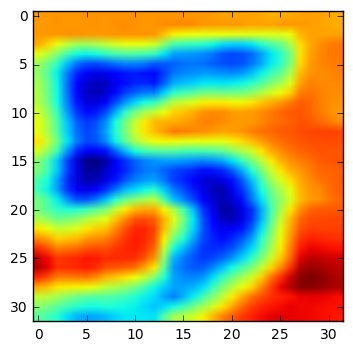

In [16]:
plt.imshow(test_data[0][0])
plt.show()


In [17]:
#pickling image data and labels
with open('test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
print('test_data pickeled')

with open('train_data.pickle', 'wb') as f:
    pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)
print('train_bbox pickeled')


test_data pickeled
train_bbox pickeled
